In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import wavespectra 

### Run the partition and track algorithm

The [ptm1_track](https://wavespectra.readthedocs.io/en/latest/generated/wavespectra.partition.partition.Partition.ptm1_track.html#wavespectra.partition.partition.Partition.ptm1_track) method partitions the spectra using the PTM1 method and combines individual wave systems

In [12]:
dset = xr.open_zarr("/source/fork/wavespectra-oceanum/data/ww3-spec.zarr")

dspart = dset.spec.partition.ptm1_track(
    swells=10,
    wspd=dset.wspd,
    wdir=dset.wdir,
    dpt=dset.dpt,
).load()

Calculate integrated wave parameters from the partitioned dataset and merge with spectra

In [13]:
dspart = xr.merge([dspart, dspart.spec.stats(["hs", "tp","fp", "dpm"]).load()])
dspart

<xarray.Dataset> Size: 8MB
Dimensions:   (dir: 24, freq: 31, site: 1, time: 256, part: 11)
Coordinates:
  * dir       (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq      (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5336 0.5869 0.6456
  * site      (site) int64 8B 0
  * time      (time) datetime64[ns] 2kB 2022-01-01 ... 2022-02-01T21:00:00
  * part      (part) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    efth      (part, time, site, freq, dir) float32 8MB 0.0 0.0 0.0 ... 0.0 0.0
    part_id   (site, part, time) int16 6kB -999 -999 -999 ... -999 -999 -999
    npart_id  (site) int64 8B 173
    hs        (part, time, site) float32 11kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tp        (part, time, site) float32 11kB nan nan nan nan ... nan nan nan
    fp        (part, time, site) float32 11kB nan nan nan nan ... nan nan nan
    dpm       (part, time, site) float32 11kB nan nan nan nan ... nan nan nan
Attributes:
    standard_name:  sea_surface_wave_directional_variance_spectral_density
    units:          m2 s degree-1
    part0:          wind sea
    part1-n:        swells in descending order of hs

The ptm1_track method defines new variables `part_id` and `n_part_id` which can be used to track the individual wave systems

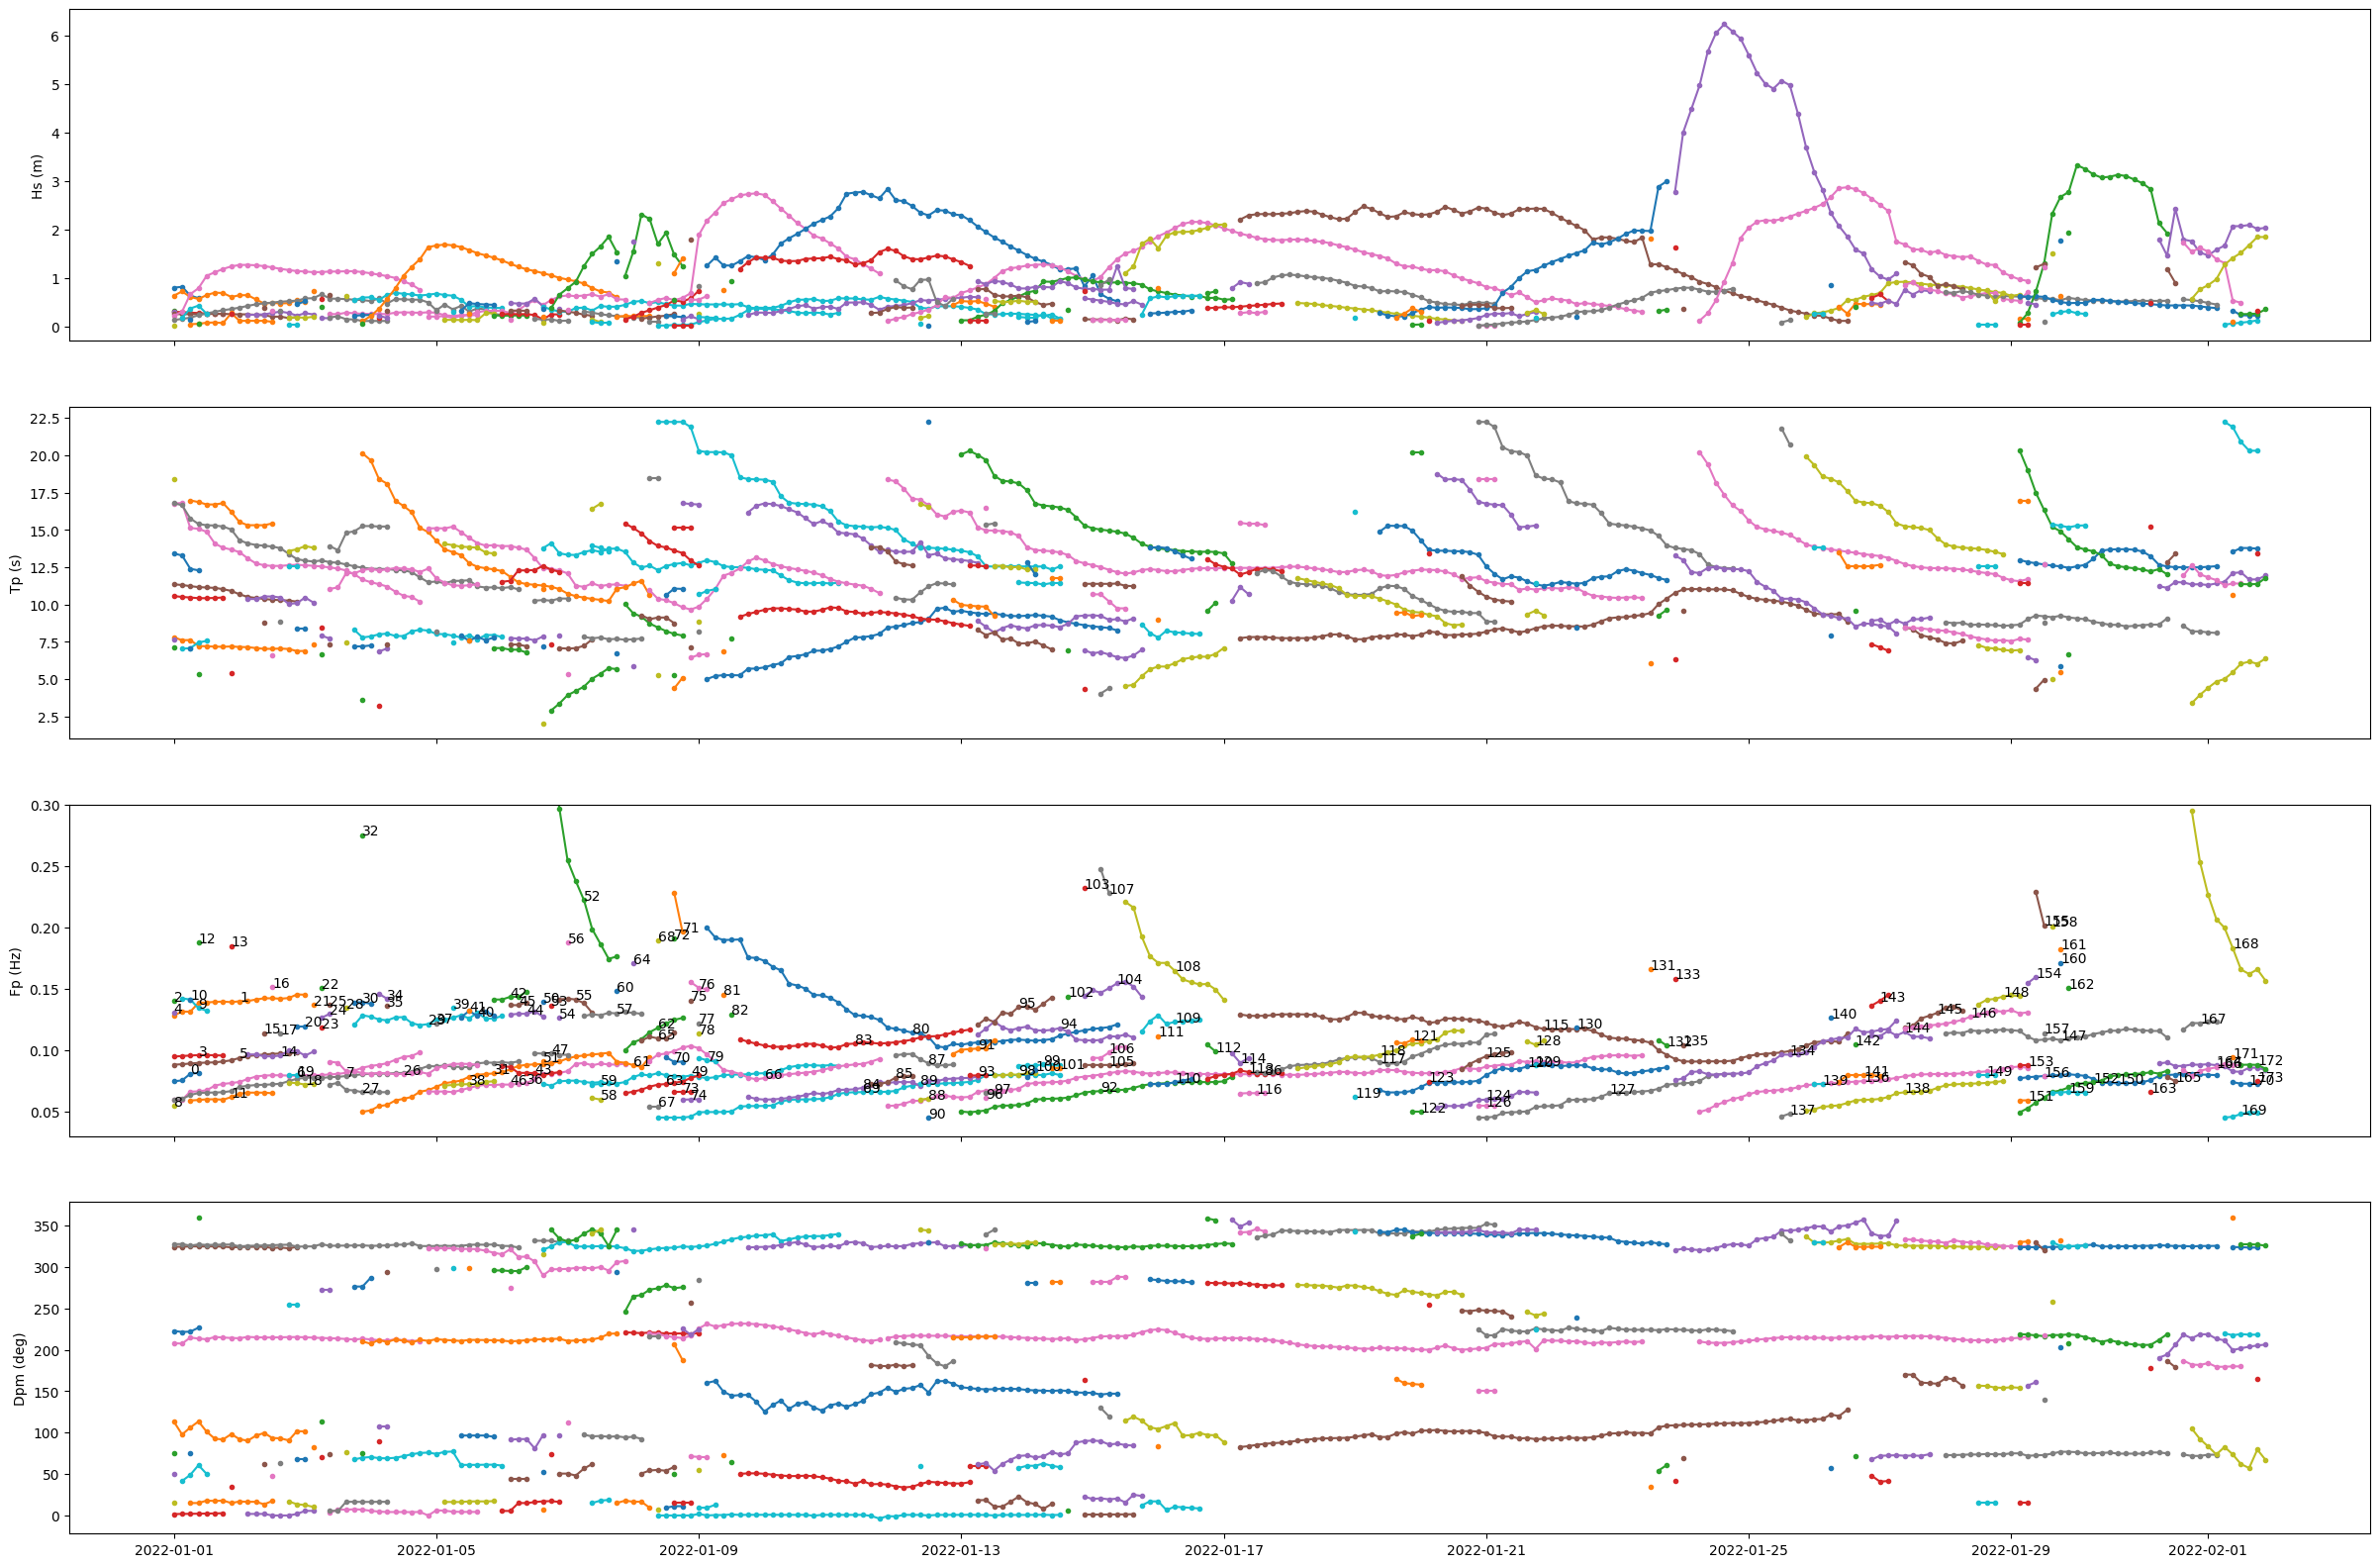

In [3]:
fig, axes = plt.subplots(figsize=(30, 20), nrows=4, ncols=1, sharex=True)

stats = dspart.isel(site=0)

for part_id in range(stats.n_part_id.values):

    pstats = stats.stack(tpart=('part', 'time')).isel(tpart=np.where(stats.part_id.values.flatten()==part_id)[0]).sortby('time')

    axes[0].plot(pstats.time, pstats.hs, ".-", label=str(part_id))
    axes[0].set_ylabel("Hs (m)")

    axes[1].plot(pstats.time, pstats.tp, ".-", label=str(part_id))
    axes[1].set_ylabel("Tp (s)")
    
    axes[2].plot(pstats.time, pstats.fp, ".-", label=str(part_id))
    axes[2].annotate(str(part_id), (pstats.time[int(pstats.time.size/2)], pstats.fp[int(pstats.time.size/2)]))
    axes[2].set_ylabel("Fp (Hz)")
    axes[2].set_ylim(0.03, 0.3)

    if np.max(pstats.dpm) - np.min(pstats.dpm) > 180:
        axes[3].plot(pstats.time, np.where(pstats.dpm < 180, pstats.dpm, pstats.dpm-360), ".-", label=str(part_id))
    else:
        axes[3].plot(pstats.time, pstats.dpm, ".-", label=str(part_id))
    axes[3].set_ylabel("Dpm (deg)")